# Step 1 : Loading the weather data

In [26]:
import pandas as pd
import glob
import os

def load_weather_data(file_pattern):
    """
    Reads multiple csv.gz files and combines them into a single DataFrame.
    """
    file_list = glob.glob(file_pattern)
    
    if not file_list:
        print("No files found matching the pattern.")
        return None

    print(f"Found {len(file_list)} files. Beginning processing...")

    dataframes = []

    for file in file_list:
        try:
            df = pd.read_csv(
                file, 
                compression='gzip', 
                sep=';',  
                encoding='utf-8', 
                low_memory=False,
                usecols=['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'TNTXM']
            )
            
            dataframes.append(df)
            print(f"Successfully loaded: {file}")
            
        except Exception as e:
            print(f"Error loading {file}: {e}")

    
    print("Concatenating files...")
    full_df = pd.concat(dataframes, ignore_index=True)
    print(f"Done! Final shape: {full_df.shape}")
    return full_df

pattern = "./data/Q_*_previous-*-*_RR-T-Vent.csv.gz"
weather_df = load_weather_data(pattern)

# Preview the data
weather_df.head()

Found 6 files. Beginning processing...
Successfully loaded: ./data\Q_18_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_28_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_36_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_37_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_41_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_45_previous-1950-2023_RR-T-Vent.csv.gz
Concatenating files...
Done! Final shape: (5650137, 8)


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,TNTXM
0,18003002,LES AIX,47.216667,2.55,182,19500101,0.0,NaN
1,18003002,LES AIX,47.216667,2.55,182,19500102,1.6,NaN
2,18003002,LES AIX,47.216667,2.55,182,19500103,5.4,NaN
3,18003002,LES AIX,47.216667,2.55,182,19500104,2.0,NaN
4,18003002,LES AIX,47.216667,2.55,182,19500105,1.9,NaN


In [35]:

distinct_postes = weather_df['NUM_POSTE'].nunique()
print(f"Number of distinct NUM_POSTE: {distinct_postes}")

    
missing_rows_count = weather_df.isnull().any(axis=1).sum()
N = weather_df.shape[0]
print(f"Number of lines with at least one missing value: {missing_rows_count} ({100*missing_rows_count/N:.0f} %)")

Number of distinct NUM_POSTE: 468
Number of lines with at least one missing value: 3239729 (57 %)


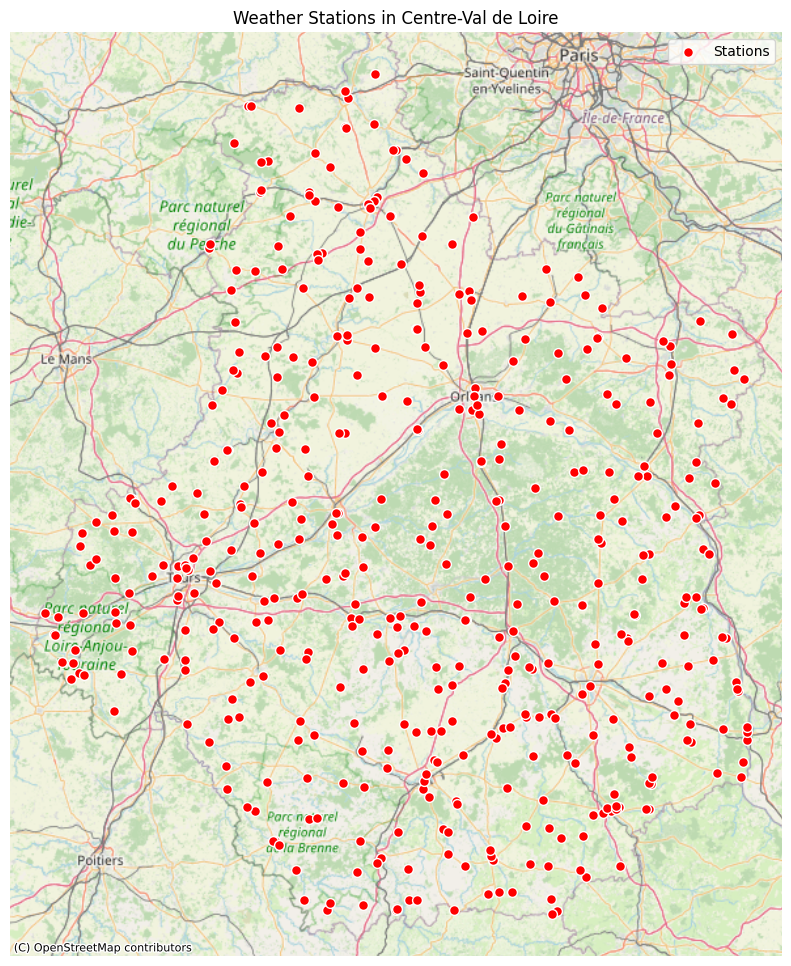

In [39]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Extract unique stations
stations = weather_df[['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON']].drop_duplicates()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    stations, 
    geometry=gpd.points_from_xy(stations.LON, stations.LAT), 
    crs="EPSG:4326"
)

# Plot
gdf_web = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

gdf_web.plot(ax=ax, color='red', markersize=50, edgecolor='white', label='Stations')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off() # Hide axis numbers for a cleaner map look
plt.title("Weather Stations in Centre-Val de Loire")
plt.legend()
plt.show()

# Step 2 : Filling missing values

In [41]:
import pandas as pd
import numpy as np
import pygam
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel


weather_df['DATE_OBJ'] = pd.to_datetime(weather_df['AAAAMMJJ'], format='%Y%m%d')


weather_df['day_of_year'] = weather_df['DATE_OBJ'].dt.dayofyear
weather_df['year'] = weather_df['DATE_OBJ'].dt.year

train_df = weather_df.dropna(subset=['TNTXM'])
missing_df = weather_df[weather_df['TNTXM'].isnull()]

X_train = train_df[['LON', 'LAT', 'ALTI', 'day_of_year', 'year']].values
y_train = train_df['TNTXM'].values

# Spatial Generalized Additive Model (GAM)
print("Fitting GAM...")

gam = pygam.LinearGAM(
    pygam.te(0, 1, n_splines=10) +  # 0 (LON) and 1 (LAT)
    pygam.s(2, n_splines=10) +      # Elevation
    pygam.s(3, basis='cp', n_splines=10) + # Seasonality (Cyclic)
    pygam.s(4, n_splines=10)        # Year
)

gam.fit(X_train, y_train)
print("GAM Fit complete.")

#train_df['gam_pred'] = gam.predict(X_train)
#train_df['residuals'] = train_df['TNTXM'] - train_df['gam_pred']

Fitting GAM...
GAM Fit complete.


C:\Users\debat\AppData\Local\Temp\ipykernel_12104\3817188583.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  station_hull = gdf_stations_day.unary_union.convex_hull


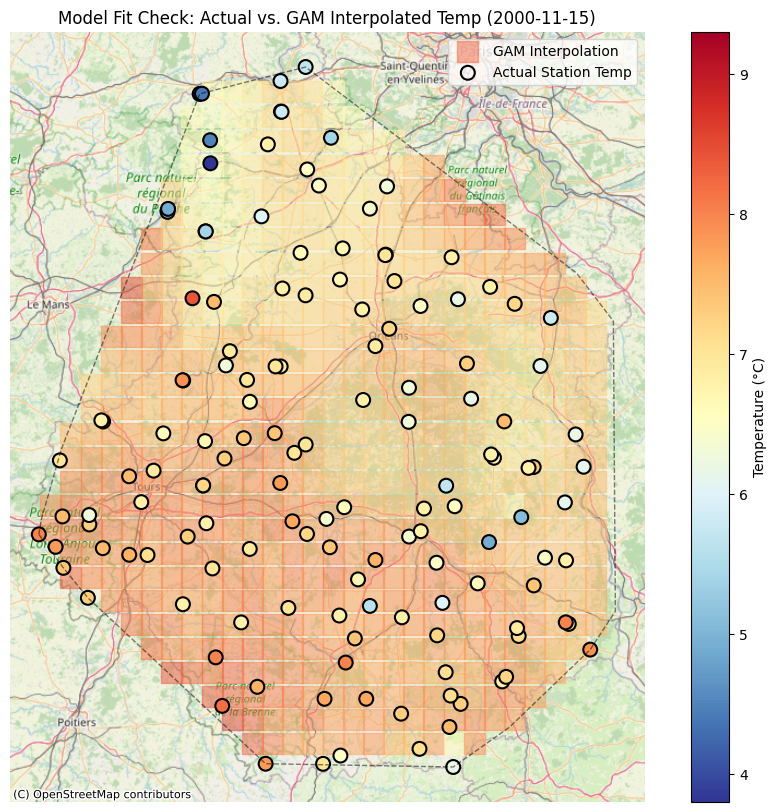

In [58]:
from scipy.interpolate import griddata

# Define target date
target_date_str = "2000-11-15"
target_date = pd.to_datetime(target_date_str)

# Filter stations for the target date
df_day = weather_df[weather_df['DATE_OBJ'] == target_date].copy()

if len(df_day) == 0:
    raise ValueError(f"No data found for date: {target_date_str}")

# --- 2. Create Grid & Predict (Same as before) ---
# Define bounds
x_min, x_max = weather_df['LON'].min(), weather_df['LON'].max()
y_min, y_max = weather_df['LAT'].min(), weather_df['LAT'].max()

# Create meshgrid
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, 30),
    np.linspace(y_min, y_max, 30)
)
flat_lon = grid_x.ravel()
flat_lat = grid_y.ravel()

# Interpolate Elevation
known_points = weather_df[['LON', 'LAT']].values # Use all known locations for better elevation map
known_alti = weather_df['ALTI'].values
grid_alti = griddata(known_points, known_alti, (flat_lon, flat_lat), method='nearest')

# Prepare prediction input
grid_n = len(flat_lon)
day_val = target_date.dayofyear
year_val = target_date.year
X_grid = np.column_stack((flat_lon, flat_lat, grid_alti, np.full(grid_n, day_val), np.full(grid_n, year_val)))

# Predict
pred_temp = gam.predict(X_grid)

# Create GeoDataFrame for Grid
pred_df = pd.DataFrame({'LON': flat_lon, 'LAT': flat_lat, 'TEMP': pred_temp})
gdf_grid = gpd.GeoDataFrame(pred_df, geometry=gpd.points_from_xy(pred_df.LON, pred_df.LAT), crs="EPSG:4326")

# Create GeoDataFrame for Stations (on that specific day)
gdf_stations_day = gpd.GeoDataFrame(df_day, geometry=gpd.points_from_xy(df_day.LON, df_day.LAT), crs="EPSG:4326")

# --- 3. Filter by Convex Hull (Same as before) ---
station_hull = gdf_stations_day.unary_union.convex_hull
mask_inside = gdf_grid.within(station_hull)
gdf_grid_filtered = gdf_grid.loc[mask_inside].copy()

# --- 4. Plotting (MODIFIED) ---
# Reproject to Web Mercator
gdf_grid_web = gdf_grid_filtered.to_crs(epsg=3857)
gdf_stations_web = gdf_stations_day.to_crs(epsg=3857)
hull_web = gpd.GeoSeries([station_hull], crs="EPSG:4326").to_crs(epsg=3857)

# Get min/max temp for a consistent color scale across both plots
vmin = min(gdf_grid_web['TEMP'].min(), gdf_stations_web['TNTXM'].min())
vmax = max(gdf_grid_web['TEMP'].max(), gdf_stations_web['TNTXM'].max())
cmap = 'RdYlBu_r'

fig, ax = plt.subplots(figsize=(12, 10))

# A. Plot the Interpolated Grid (Background)
# Using a smaller s and alpha to make it a "background" layer
sc_grid = ax.scatter(
    gdf_grid_web.geometry.x, 
    gdf_grid_web.geometry.y, 
    c=gdf_grid_web['TEMP'], 
    cmap=cmap,
    vmin=vmin, vmax=vmax,
    s=230, alpha=0.5, marker='s',
    label='GAM Interpolation'
)

# B. Plot the Actual Stations (Foreground)
# Larger size, solid opacity, and a black edge to make them pop
sc_stations = ax.scatter(
    gdf_stations_web.geometry.x,
    gdf_stations_web.geometry.y,
    c=gdf_stations_web['TNTXM'],
    cmap=cmap,
    vmin=vmin, vmax=vmax,
    s=100, alpha=1.0, edgecolors='black', linewidth=1.5,
    label='Actual Station Temp'
)

# Draw Hull
hull_web.plot(ax=ax, facecolor='none', edgecolor='black', linestyle='--', linewidth=1, alpha=0.5)

# Add shared colorbar
plt.colorbar(sc_stations, ax=ax, label=f"Temperature (°C)")

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title(f"Model Fit Check: Actual vs. GAM Interpolated Temp ({target_date_str})")
plt.legend(loc='upper right')
plt.show()